### Cleaning

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('./Data/subreddit_data.csv')

In [4]:
df.head()

,Unnamed: 0,title,selftext,subreddit,created_utc
0,0,"I was suggested to post this puzzle here ,hope...",NaN,chess,1645890879
1,1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",chess,1645889769
2,2,Who is GM Watneg on lichess?,NaN,chess,1645887353
3,3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,chess,1645886429
4,4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,chess,1645885215


In [5]:
# Drop the 'Unnamed: 0' column

df.drop(columns = 'Unnamed: 0', inplace = True)

In [6]:
# Binarize the subreddit column to 0s (chess) and 1 (nba).  Doesn't matter what the positive class is.  Baseline Model will be ~50% accurate either way.

df['subreddit'] = df['subreddit'].replace({'chess': 0, 'nba':1})

In [7]:
df.isnull().sum()

title             0
selftext       1761
subreddit         0
created_utc       0
dtype: int64

In [8]:
# Impute NaNs with an empty string
df['selftext'].fillna('',inplace = True)

In [9]:
# Drop the 'created_utc' column
df.drop(columns = 'created_utc', inplace = True)

### EDA

In [10]:
# Add a new column for title length
df['title_length'] = df['title'].str.len()

In [11]:
# Add a new column for title word count
df['title_word_count'] = [len(title.split(' ')) for title in df['title']]

In [12]:
df.head()

,title,selftext,subreddit,title_length,title_word_count
0,"I was suggested to post this puzzle here ,hope...",,0,65,14
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7
2,Who is GM Watneg on lichess?,,0,28,6
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34


In [13]:
df.sort_values('title_word_count', ascending = False)[['title']]

,title
2939,Krause on MJ: He knew that he could do things ...
2002,[ESPN Stats &amp; Info] A new Big 3 brewing in...
279,Why is this move that good? I've been analyzin...
3643,"[Vardon] Giannis: “All-Star Games, they are no..."
3024,Danny Green on if Simmons will play March 10th...
...,...
1220,Help
3145,Hdjsusbeebbggff
1844,1660
216,Hi!


Text(0, 0.5, '# of documents')

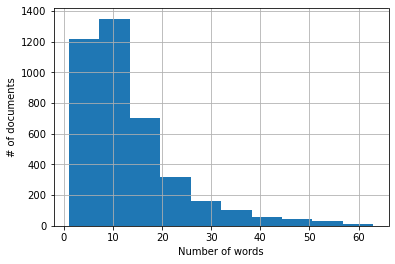

In [14]:
df['title_word_count'].hist()
plt.xlabel('Number of words')
plt.ylabel('# of documents')

Text(0, 0.5, '# of documents')

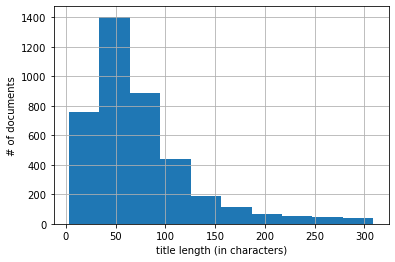

In [15]:
df['title_length'].hist()
plt.xlabel('title length (in characters)')
plt.ylabel('# of documents')

In [16]:
df.groupby('subreddit')['title_length','title_word_count'].mean()

C:\Users\aorfa\AppData\Local\Temp/ipykernel_22488/918172363.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('subreddit')['title_length','title_word_count'].mean()


,title_length,title_word_count
subreddit,,
0,63.265899,11.472208
1,85.109500,15.130000


### Vectorize the text

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [18]:
cvec = CountVectorizer(stop_words = 'english')

cvec.fit(df['title'])

csr = cvec.transform(df['title'])

title_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [19]:
title_cvec.shape

(3997, 6188)

In [20]:
# top 20 words in either subreddit titles

title_cvec.sum(axis = 0).sort_values(ascending = False)[:20]

chess        547
game         457
nba          346
play         218
white        208
time         181
black        179
lebron       174
team         166
star         158
players      151
win          149
just         138
highlight    138
best         137
games        136
player       126
com          123
like         110
mate         107
dtype: int64

In [21]:
# create new dataFrame with only the titles from the chess subreddit.  
df_chess = df[(df['subreddit'] == 0)]

In [22]:
df.shape

(3997, 5)

In [23]:
df_chess.shape

(1997, 5)

In [24]:
df_chess['subreddit'].value_counts()

0    1997
Name: subreddit, dtype: int64

In [25]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_chess['title'])
csr = cvec.transform(df_chess['title'])
chess_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [26]:
# Top 20 words in chess subreddit titles

chess_cvec.sum(axis = 0).sort_values(ascending = False)[:20]

chess       547
game        230
white       201
black       177
play        168
com         117
mate        107
win          98
just         76
lichess      70
games        69
best         68
does         60
playing      58
like         58
position     56
moves        53
time         53
players      52
draw         52
dtype: int64

In [27]:
df_nba = df[(df['subreddit'] == 1)]

In [28]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_nba['title'])
csr = cvec.transform(df_nba['title'])
nba_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [29]:
# Top 20 words in nba subreddit titles

nba_cvec.sum(axis = 0).sort_values(ascending = False)[:20]

nba          346
game         227
lebron       174
team         161
star         158
highlight    138
time         128
season       100
harden       100
players       99
james         96
curry         92
player        87
lakers        85
steph         73
best          69
games         67
mvp           65
2022          65
thread        64
dtype: int64

In [30]:
df['title']

0       I was suggested to post this puzzle here ,hope...
1          Programs for analyzing and annotating my games
2                            Who is GM Watneg on lichess?
3                              Glitch in Lichess Analysis
4       Does anyone know what the heck a zero day that...
                              ...                        
3992    It’s insane that OKC drafted 3 top 75 players ...
3993    The Suns trade for Aaron Holiday makes a lot m...
3994    KG reaction when Ray Allen gets introduced in ...
3995        The Guards in the NBA's 75th anniversary team
3996    So which one of those 75 players are we removi...
Name: title, Length: 3997, dtype: object

In [31]:
# try vectorizing on a token pattern that detects any two consecutive capitalized words

cvec = CountVectorizer(stop_words = 'english', lowercase = False, token_pattern = '([A-Z][a-z]+(?=\s[A-Z])(?:\s[A-Z][a-z]+)+)')
cvec.fit(df['title'])
csr = cvec.transform(df['title'])
twocaps_cvec = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

In [32]:
twocaps_cvec.head()

,Aaron Fox,Aaron Fox Scams,Aaron Gordon,Aaron Holiday,Abram Khasin,Adam Aaronson,Adds Durant,Adult Improver,Affiliate Club,After Esipenko,Agent Met With Lakers,Aggressive Chess Mug,Agua Calienta,Airthings Final,Airthings Master,Airthings Masters,Al Horford,Alamo Square Park Chess Club,Alex Caruso,Alex Len,Alexandra Kosteniuk,All About Your Rating,All Defensive,All Star,All Star Break,All Star Break Edition,All Star Game,All Star Game Stream,All Star Weekend Vlog,All Stars,All The Top,All This Just,All Time,Allen Iverson,Almost Choked,Already One,Amish Girl Twitter Hacked,Analysis Board,Anatoly Karpov,Andre Ayton,Andre Drummond,Andrea Botez,Andrejs Strebvoks,Andrew Bynum,Andrew Lopez,Andrew Martin,Andrew Salciunas,Andrew Wiggins,Andrey Esipenko,Anfernee Simons,Angelo Russell,Animoca Brands,Anish Doxxes Gotham,Anish Giri,Anish Giris Profile Picture,Anna Rudolf,Anniversary Team,Anniversary Team Ceremony,Anniversary Team Rankings,Anniversary Worst Players,Announcing Winners Of The Chess,Annual Kasparov Chess Foundation University Cup,Ant Davis,Ant Puts,Antawn Jamison,Anthony Chiang,Anthony Davis,Anthony Edwards,Anthony Mc,Anthony Towns,Anti Blunder Puzzle Theme,Anwesh Upadhyaya,Appreciation Post,Are Humans Still Useful,Armed Forces,Arthur Feuerstein,Artis Gilmore,Asian Americans,Asked Nikola Jokic,Atlanta Hawks,Austin Krell,Austin Reaves,Austin Reeves Lakers,Automatic Points From Fouls,Avery Bradley,Ayo Crosses Trae Young And Puts Up An Easy Bucket,Ayo Dosunmu,Azerbaijan Championship,Back Home Safe,Bad Boy Piston Isiah Thomas,Bad Boys,Baden Baden,Ball Reference,Ban Sergey Karjakin,Base News Article,Basic Read,Basketball Color,Basketball Hall,Basketball Hall Of Fame Inducte Sidney Moncrief Talks Giannis,Basketball Network,Basketball Operations,Basketball Reference,Basketball World Cup,Batard Show,Bay Area,Beating Alireza Firouzja,Beautiful Relationship,Beautiful Sicilian,Became Flustered,Before Black,Beginner Stafford,Ben Finegold,Ben Simmon,Ben Simmons,Ben Simmons Edition,Ben Taylor,Ben Wallace,Berlin Defense,Berlin Grand Prix,Best Carlsen,Best Chess Players,Best Defensive Teams,Best Games,Best Headphones,Best Home Gym Equipment,Best Japanese Rice Cooker,Best Move,Best Offensive Basketball Team Ever,Best Passers,Best Player Every,Best Playmaking Badges For Any Build,Better Leader,Bharath Subramaniyam,Big Apple,Biggest Winners,Bill Duffy,Bill Oram,Bill Plaschke,Bill Russell,Bill Simmons,Bill Walton,Billy Cunningham,Billy Donovan,Black Bear Wanted,Black Master,Blowouts Have Great Announcing,Blue Wire,Bob Petit,Bobby Fischer,Bongcloud Speedrun,Book Recommendations,Book Review,Book Study,Boris Gulko,Borislav Ivkov,Boston Celtics,Both Shai,Brad Miller,Bradley Beal Trade Before James Harden Deal,Brandon Roy,Brandon Weems,Brandon Williams,Brazilian Maid Who Became,Breaking News,Brenda Tersine,Brian Barrett,Brian Windhorst,Brilliancy The,Brilliant Move,Broadcast Is Better Than,Bron Delivers,Bron Introduced,Bron James,Bron James Theory,Bron Leaving The Lakers Hurt His Legacy,Bron Needs To Be,Bronny James,Bronny James Hypothetical,Brooklyn Nets,Buddy Hield,Bullet Chess,Bullet Chess Championship,Burner Accounts,Buying Tips,By The,Cade Cunningham,Calculations Strategies,Caleb Martin,Callie Caplan,Calvin Murphy,Cam Johnson,Can Bronny,Can Le,Can Lichess Mods See Your Cheating Report If Your Account Is Muted,Candidates On,Candidates Tournament,Capital City Go Go They,Career After,Career High,Carmelo Anthony,Casey Vitelli,Cavaliers Point Guards Are Cursed,Centipawn Loss,Certain Someone,Certifying Greatness,Champions Chess Tour,Champions Showdown Blitz,Championship Odds,Chandler Parsons,Charles Barkley,Charles Oakley,Charlotte Hornets,Chauncey Billups,Checking If,Cheesecake Factories,Chess Arena,Chess Because It Looks Simple,Chess Boards,Chess Book,Chess Champ,Chess Champion,Chess Clothing Store Kings,Chess Club,Chess Coach,Chess Content,Chess Experience,Chess Experience Giveaway,Chess Grand Prix,Chess Grandmaster,Chess Group Training,Chess Lover,

In [33]:
# create a column that combines the text in 'title' and 'selftext'
# first fill the missing values in selftext with an empty string
df['selftext'].fillna('')
df['title_selftext'] = df['title'] + df['selftext']

In [34]:
df.head()

,title,selftext,subreddit,title_length,title_word_count,title_selftext
0,"I was suggested to post this puzzle here ,hope...",,0,65,14,"I was suggested to post this puzzle here ,hope..."
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,Programs for analyzing and annotating my games...
2,Who is GM Watneg on lichess?,,0,28,6,Who is GM Watneg on lichess?
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,Glitch in Lichess Analysis&amp;#x200B;\n\n[I w...
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,Does anyone know what the heck a zero day that...


## Sentiment Analysis

In [35]:
# Add Sentiment score columns to the main df
# Instantiate Sentiment Intensity Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [36]:
df['sentiment'] = df['title'].apply(sia.polarity_scores)
df.head()

,title,selftext,subreddit,title_length,title_word_count,title_selftext,sentiment
0,"I was suggested to post this puzzle here ,hope...",,0,65,14,"I was suggested to post this puzzle here ,hope...","{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp..."
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,Programs for analyzing and annotating my games...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Who is GM Watneg on lichess?,,0,28,6,Who is GM Watneg on lichess?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,Glitch in Lichess Analysis&amp;#x200B;\n\n[I w...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,Does anyone know what the heck a zero day that...,"{'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'comp..."


In [37]:
df['sentiment_compound'] = df['sentiment'].map(lambda x: x['compound'])
df['sentiment_negative'] = df['sentiment'].map(lambda x: x['neg'])
df['sentiment_neutral'] = df['sentiment'].map(lambda x: x['neu'])
df['sentiment_positive'] = df['sentiment'].map(lambda x: x['pos'])
df = df.drop('sentiment', 1)

C:\Users\aorfa\AppData\Local\Temp/ipykernel_22488/1652361034.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('sentiment', 1)


In [38]:
df.head()

,title,selftext,subreddit,title_length,title_word_count,title_selftext,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive
0,"I was suggested to post this puzzle here ,hope...",,0,65,14,"I was suggested to post this puzzle here ,hope...",0.8126,0.000,0.543,0.457
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,Programs for analyzing and annotating my games...,0.0000,0.000,1.000,0.000
2,Who is GM Watneg on lichess?,,0,28,6,Who is GM Watneg on lichess?,0.0000,0.000,1.000,0.000
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,Glitch in Lichess Analysis&amp;#x200B;\n\n[I w...,0.0000,0.000,1.000,0.000
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,Does anyone know what the heck a zero day that...,-0.5043,0.121,0.879,0.000


In [39]:
df.to_csv('./Data/subreddit_data_post_eda.csv', index = False)